<a href="https://colab.research.google.com/github/blhuillier/2025B_AstroDataAnalysis/blob/main/Notebooks/Chap_7_Resampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jackknife and Bootstrap — Resampling Exercises

Objectives:
- Demonstrate the jackknife and bootstrap for parameter uncertainty estimation.
- Compute pseudovalues, jackknife bias correction and jackknife variance.
- Compare jackknife and bootstrap uncertainty estimates for a weighted least-squares fit.

Prerequisites: basic Python, NumPy, Matplotlib, and understanding of weighted least-squares.

Key formulas (for reference):
- Pseudovalue: $\psi_i = N \hat{\theta} - (N-1) \hat{	\theta}_{(i)}$
- Jackknife estimate: $\hat{\theta}_J = \frac{1}{N} \sum_i \psi_i$
- Jackknife variance: $\mathrm{Var}_J = \frac{1}{N(N-1)} \sum_i (\psi_i - \hat{	\theta}_J)^2$

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# plotting colors used in examples
mycols = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Example 1. Jackknife
$$\theta = S^2(X) = \frac 1 N \sum_{i=1}^N (X_i-\bar X)^2$$

# Example 2: Unbiased variance estimator



# Exercise - Jacknife

1. Perform a linear fit with the model:
$$y = ax^2 + b x + c$$

2. Estimate (a,b,c) with the Jacknife:
  1. estimate the pseudovalues
  2. Give the mean and standard deviation of $(a,b,c)$
  2. Make a histogram of the pseudo-values
  2. make a triangle plot of the pseudo-values

In [2]:

a,b,c = 1,-2,3
theta_true = [a,b,c]

r = np.random.RandomState(42)
NN = 10
xx = r.uniform(0,1,NN)
sigma = 0.05 / (1+xx)
epsilon = r.normal(0,1,NN) * sigma

inv_cov = np.diag(1/sigma**2)


def func(theta,xx):
    a, b, c = theta
    return a*xx**2 + b*xx + c

yy = func(theta_true, xx) + epsilon

AA = np.vstack((xx**2, xx, np.ones_like(xx))).T
print (AA.shape)

thetahat = np.linalg.solve(AA.T @ inv_cov @ AA, AA.T @ inv_cov @ yy)
print (thetahat)


chi2 = ((yy - func(thetahat, xx))**2 / sigma**2).sum()
print (chi2, NN - len(theta_true))

(10, 3)
[ 0.9726127  -1.90584008  2.93880808]
4.047359816771929 7


In [3]:
# Pseudovalues: compute leave-one-out estimates and corresponding pseudo-values
# `psistar` stores the pseudovalues (one per omitted observation),
# `thetahat_i` stores the leave-one-out parameter estimates.
psistar = np.zeros((NN,len(thetahat)))
thetahat_i = np.zeros((NN,len(thetahat)))

for ii in range(NN):
    # build the leave-one-out dataset by removing index `ii`
    xstar = np.concatenate((xx[:ii],xx[ii+1:]))
    # y values with the i-th point removed
    ystar = np.concatenate((yy[:ii], yy[ii+1:]))
    # design matrix for the reduced dataset
    AA_i = np.vstack((xstar**2, xstar, np.ones_like(xstar))).T
    # use the corresponding uncertainties for the reduced dataset
    thissigma = np.concatenate((sigma[:ii], sigma[ii+1:]))
    # inverse covariance for the reduced dataset (diagonal here)
    this_inv_cov = np.diag(1/thissigma**2)
    # weighted least-squares on the reduced dataset
    thetahat_i[ii] = np.linalg.solve(AA_i.T @ this_inv_cov @ AA_i, AA_i.T @ this_inv_cov @ ystar)
    # pseudovalue definition: psi_i = N*thetahat - (N-1)*thetahat_(i)
    psistar [ii,:] = NN * thetahat - (NN-1) * thetahat_i[ii,:]
    # (optionally) print or store thetahat_i[ii] for diagnostics

In [4]:
# Compute jackknife summary statistics
# theta_J: mean of pseudo-values (bias-corrected estimate)
theta_J = psistar.mean(axis=0)
print (f"theta_J (pseudo-value mean) = {theta_J}")
# theta_dot: average of the leave-one-out estimates
theta_dot = thetahat_i.mean(axis=0)
print (f"theta_dot (mean leave-one-out) = {theta_dot}")
# thetahat is the full-sample weighted least-squares estimate
print (f"thetahat (full-sample) = {thetahat}")
# identity check: algebraic relation between pseudo-values and leave-one-out means
check_identity = np.allclose(theta_J, NN*thetahat - (NN-1)*theta_dot)
print(f"theta_J == N*thetahat - (N-1)*theta_dot ? {check_identity}")
# jackknife bias estimate: (N-1)*(theta_dot - thetahat)
bias_J = (NN-1) * (theta_dot - thetahat)
print (f"bias_J (jackknife estimate of bias) = {bias_J}")
# show how theta_J relates to thetahat via the estimated bias
print (f"theta_J - thetahat (should equal -bias_J) = {theta_J - thetahat}")
# variance via pseudo-values (standard jackknife variance)
var_J_psival = ((psistar - theta_J)**2).sum(axis=0) / (NN * (NN-1))
# equivalent variance computed from leave-one-out estimates
var_J_loo = ((thetahat_i - theta_dot)**2).sum(axis=0) * (NN-1) / NN
print(f"sqrt(var) pseudo-values: {np.sqrt(var_J_psival)}")
print(f"sqrt(var) leave-one-out: {np.sqrt(var_J_loo)}")
print(f"difference between var estimates: {np.abs(var_J_psival - var_J_loo)}")

theta_J (pseudo-value mean) = [ 1.01099073 -1.93130655  2.93873235]
theta_dot (mean leave-one-out) = [ 0.96834847 -1.90301048  2.9388165 ]
thetahat (full-sample) = [ 0.9726127  -1.90584008  2.93880808]
theta_J == N*thetahat - (N-1)*theta_dot ? True
bias_J (jackknife estimate of bias) = [-3.83780390e-02  2.54664687e-02  7.57343590e-05]
theta_J - thetahat (should equal -bias_J) = [ 3.83780390e-02 -2.54664687e-02 -7.57343590e-05]
sqrt(var) pseudo-values: [0.13278921 0.15063745 0.04454823]
sqrt(var) leave-one-out: [0.13278921 0.15063745 0.04454823]
difference between var estimates: [6.93889390e-18 1.38777878e-17 2.60208521e-18]


# Exercise: Bootstrapping

1. Estimate the parameters and their error with the bootstrap method


## Bootstrap esimtation of the uncertainty on $\hat {\theta}$



In [5]:
# Bootstrap resampling to estimate uncertainty on the fitted parameters
# We draw indices with replacement and re-fit the model to the resampled dataset.
BB = 10_000

r = np.random.RandomState(42)

# container for bootstrap parameter estimates (one row per resample)
theta_hat_star = np.zeros((BB,3))

for ii in range (BB):
    # draw bootstrap sample indices (with replacement)
    istar = r.randint(NN,size=NN)
    # create resampled x and y arrays
    xstar = xx[istar]
    ystar = yy[istar]
    # use the corresponding submatrix of the inverse covariance
    # (this preserves any weighting defined by `inv_cov`)
    this_inv_cov = inv_cov[np.ix_(istar,istar)]
    AAstar = np.vstack((xstar**2, xstar, np.ones_like(xstar))).T
    # weighted least-squares on the bootstrap sample
    theta_hat_star[ii,:] = np.linalg.solve(AAstar.T @ this_inv_cov @ AAstar, AAstar.T @ this_inv_cov @ ystar)

# theta_hat_star now contains BB bootstrap estimates
print (theta_hat_star)

[[ 0.64015807 -1.61263125  2.91437327]
 [ 1.08399623 -2.00905692  2.93703338]
 [ 0.91415387 -1.84223521  2.93160159]
 ...
 [ 1.15095875 -2.17889112  3.03083371]
 [ 0.83359905 -1.73476688  2.88528113]
 [ 1.04422006 -2.04213918  2.99468002]]


In [6]:
print (istar)
np.ix_(istar,istar)
print (inv_cov[np.ix_(istar,istar)])

[7 7 6 1 4 4 3 0 3 0]
[[1393.04536282 1393.04536282    0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [1393.04536282 1393.04536282    0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.            0.          447.81637214    0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.            0.            0.         1522.11452209    0.
     0.            0.            0.            0.            0.        ]
 [   0.            0.            0.            0.          534.55163882
   534.55163882    0.            0.            0.            0.        ]
 [   0.            0.            0.            0.          534.55163882
   534.55163882    0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.         1022.28357964    0.         1022.28357964    0.        ]
 [ 

In [7]:
theta_hat_BS = theta_hat_star.mean(axis=0)
sigma_theta_BS = theta_hat_star.std(axis=0)
print (rf"\hat{{\theta}}^* = {theta_hat_BS}")
print (rf"\sigma(\hat{{\theta}})^* = {sigma_theta_BS}")

\hat{\theta}^* = [ 0.95527048 -1.89520334  2.93946156]
\sigma(\hat{\theta})^* = [0.20739439 0.25406715 0.08009485]


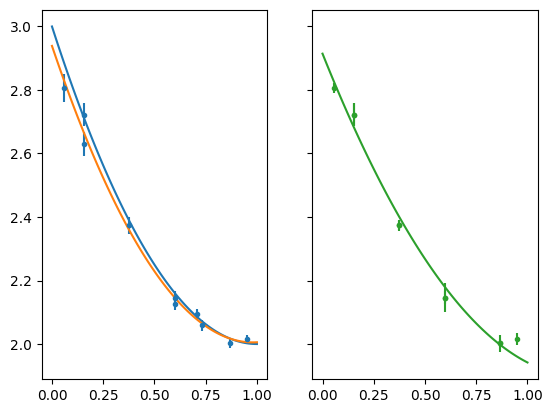

In [8]:
fig, ax = plt.subplots(1,2,sharex=True,sharey=True)
iax = ax[0]
iax.errorbar(xx,yy,sigma / (1+xx),ls='', marker='.')
x0 = np.linspace(0,1,num=101)
iax.plot(x0, func(theta_true,x0), color=mycols[0])
iax.plot(x0, func(thetahat,x0), color=mycols[1])

iax = ax[1]
for ii in range(1):
  iax.errorbar(xstar,ystar,sigma / (1+xx),ls='', marker='.',color=mycols[2])
  iax.plot(x0, func(theta_hat_star[ii],x0), color=mycols[2])






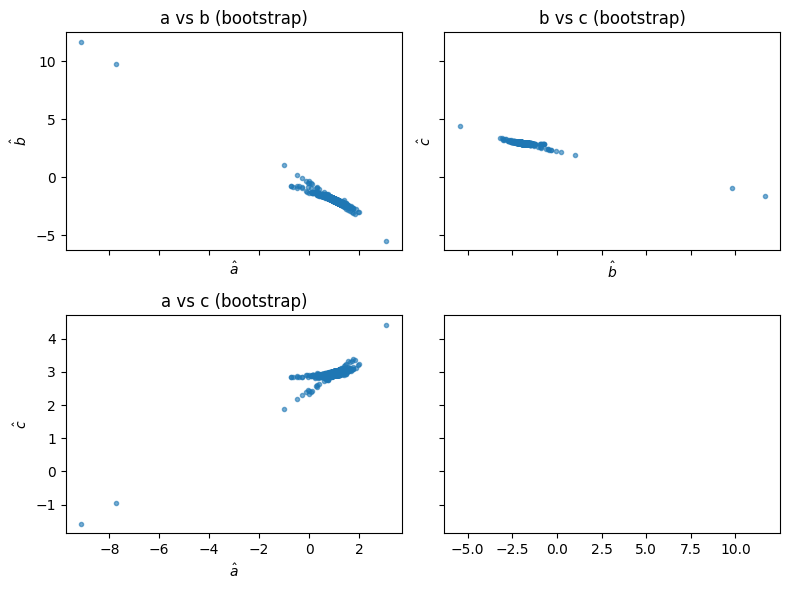

In [9]:
# Pairwise scatter plots of bootstrap parameter estimates
fig, ax = plt.subplots(2,2, sharex='col', sharey='row', figsize=(8,6))
# a vs b
iax = ax[0,0]
iax.scatter(theta_hat_star[:,0], theta_hat_star[:,1], marker='.', alpha=0.6)
iax.set_xlabel(r"$\hat{a}$")
iax.set_ylabel(r"$\hat{b}$")
iax.set_title('a vs b (bootstrap)')
# a vs c
iax = ax[1,0]
iax.scatter(theta_hat_star[:,0], theta_hat_star[:,2], marker='.', alpha=0.6)
iax.set_xlabel(r"$\hat{a}$")
iax.set_ylabel(r"$\hat{c}$")
iax.set_title('a vs c (bootstrap)')
# b vs c
iax = ax[0,1]
iax.scatter(theta_hat_star[:,1], theta_hat_star[:,2], marker='.', alpha=0.6)
iax.set_xlabel(r"$\hat{b}$")
iax.set_ylabel(r"$\hat{c}$")
iax.set_title('b vs c (bootstrap)')
# diagonal: leave bottom-right empty or use histogram
# ax[1,1].hist(theta_hat_star[:,0], bins=20, alpha=0.6)
# ax[1,1].set_title('marginal (a)')
# plt.suptitle('Bootstrap parameter pairs')
plt.tight_layout()

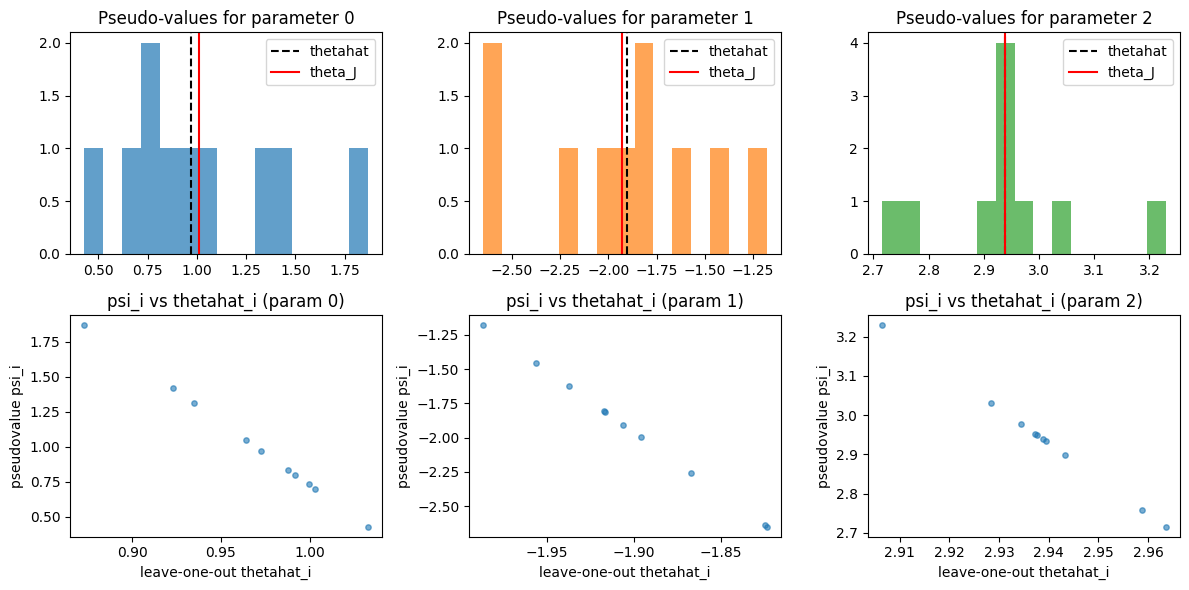

In [10]:
# Visualize pseudovalues (jackknife) and leave-one-out estimates
fig, axes = plt.subplots(2,3, figsize=(12,6))
for i in range(3):
    ax = axes[0,i]
    ax.hist(psistar[:,i], bins=15, alpha=0.7, color=mycols[i])
    ax.axvline(thetahat[i], color='k', linestyle='--', label='thetahat')
    ax.axvline(theta_J[i], color='r', linestyle='-', label='theta_J')
    ax.set_title(f'Pseudo-values for parameter {i}')
    ax.legend()
    ax = axes[1,i]
    ax.scatter(thetahat_i[:,i], psistar[:,i], s=15, alpha=0.6)
    ax.set_xlabel('leave-one-out thetahat_i')
    ax.set_ylabel('pseudovalue psi_i')
    ax.set_title(f'psi_i vs thetahat_i (param {i})')
plt.tight_layout()